# **Analisando a Violência no Rio de Janeiro**

O Rio de Janeiro é mundialmente conhecido por suas belezas naturais e arquitetônicas. As atrações do estado vão desde suas famosas praias até o [Cristo Redentor](https://pt.wikipedia.org/wiki/Cristo_Redentor), uma das Sete Maravilhas do mundo moderno.

Sede da final da Copa do Mundo de 2014 e das Olímpiadas 2016, dois dos maiores eventos espotivos do mundo, o Rio de Janeiro ficou ainda mais em evidência global. Essa evidência também colocou em foco um dos pricipais problemas que assolam o estado há anos: a violência. Durante o período dos jogos Olímpicos, por exemplo, a [imprensa internacional](https://www.washingtonpost.com/news/worldviews/wp/2016/07/05/welcome-to-hell-violence-rocks-rio-a-month-before-olympics/) também passou a discutir este problema, o que a [imprensa nacional](https://www.gazetadopovo.com.br/opiniao/editoriais/violencia-corrupcao-e-falencia-ocaos-no-rio-de-janeiro-6ms9gi3utm3t51qr8sd53zdvz/) já faz há mais tempo.

![alt text](https://www.imagemhost.com.br/images/2020/06/13/Violencia-Rio-de-Janeiro1-1280x720.jpg)

Ciente desta grave situação, o governo do estado vem, há algum tempo, disponibilizando dados sobre os mais diversos tipos de crimes registrados todos os meses no estado em seu [site oficial](http://www.ispdados.rj.gov.br/estatistica.html). Além disso, um [*dashboard*](http://www.ispvisualizacao.rj.gov.br/index.html) interativo também é disponibilizado, permitindo que o cidadão acompanhe os casos de violências em todas as regiões do estado. Desta forma, vamos utilizar estes dados para estudar os número des crimes no Rio de Janeiro.

O *dataset* que será utilizado contém números mensais de crimes desde o ano de 1991 até o ano de 2019. Através destes dados, este projeto tem como objetivo realizar análises sobre alguns dos diferentes tipos de ocorrência, mais especificamente:

* Verificar o comportamento das ocorrências envolvendo veículos e como estas se relacionam entre si;
* Analisar o comportamento do número de casos de homicídio doloso, tentando identificar uma possível tendência e criando um modelo preditivo para os próximos 12 meses.

## **Análise Exploratória e Limpeza dos Dados**

Vamos começar importando as bibliotecas:

* `pandas`, para manipulação de dados;
* `matplotlib` e `seaborn`, para visuaização de dados;
* `fbprophet`, para criar um modelo de séries temporais.

Com tudo importado, vamos criar o dataframe e ver suas primeiras cinco linhas.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics

%matplotlib inline
sns.set_style('darkgrid')

rio = pd.read_csv('https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/violencia_rio.csv')

rio.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,vano,mes,hom_doloso,lesao_corp_morte,latrocinio,hom_por_interv_policial,tentat_hom,lesao_corp_dolosa,estupro,hom_culposo,lesao_corp_culposa,roubo_comercio,roubo_residencia,roubo_veiculo,roubo_carga,roubo_transeunte,roubo_em_coletivo,roubo_banco,roubo_cx_eletronico,roubo_celular,roubo_conducao_saque,roubo_apos_saque,roubo_bicicleta,outros_roubos,total_roubos,furto_veiculos,furto_transeunte,furto_coletivo,furto_celular,furto_bicicleta,outros_furtos,total_furtos,sequestro,extorsao,sequestro_relampago,estelionato,apreensao_drogas,posse_drogas,trafico_drogas,apreensao_drogas_sem_autor,recuperacao_veiculos,apf,aaapai,cmp,cmba,ameaca,pessoas_desaparecidas,encontro_cadaver,encontro_ossada,pol_militares_mortos_serv,pol_civis_mortos_serv,indicador_letalidade,indicador_roubo_rua,indicador_roubo_veic,registro_ocorrencias,fase
0,1991,1,657,NaN,15,NaN,162,3051,NaN,NaN,NaN,350,188,1174,63,967,381,37,NaN,NaN,NaN,NaN,NaN,158,3318,2009,1147,NaN,NaN,NaN,3561,6717,NaN,NaN,NaN,NaN,133,NaN,NaN,NaN,872,NaN,NaN,NaN,NaN,NaN,NaN,217,NaN,NaN,NaN,672,1348,1174,NaN,3
1,1991,2,732,NaN,17,NaN,175,3421,NaN,NaN,NaN,357,171,1097,64,963,432,35,NaN,NaN,NaN,NaN,NaN,142,3261,1850,1066,NaN,NaN,NaN,3309,6225,NaN,NaN,NaN,NaN,127,NaN,NaN,NaN,751,NaN,NaN,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,749,1395,1097,NaN,3
2,1991,3,713,NaN,25,NaN,216,3613,NaN,NaN,NaN,443,191,1265,71,963,422,43,NaN,NaN,NaN,NaN,NaN,131,3529,2084,1062,NaN,NaN,NaN,3573,6719,NaN,NaN,NaN,NaN,80,NaN,NaN,NaN,789,NaN,NaN,NaN,NaN,NaN,NaN,188,NaN,NaN,NaN,738,1385,1265,NaN,3
3,1991,4,634,NaN,20,NaN,200,3211,NaN,NaN,NaN,425,199,1415,81,1186,354,36,NaN,NaN,NaN,NaN,NaN,112,3808,2085,1195,NaN,NaN,NaN,3290,6570,NaN,NaN,NaN,NaN,133,NaN,NaN,NaN,787,NaN,NaN,NaN,NaN,NaN,NaN,140,NaN,NaN,NaN,654,1540,1415,NaN,3
4,1991,5,650,NaN,20,NaN,146,3051,NaN,NaN,NaN,553,231,1449,82,931,335,27,NaN,NaN,NaN,NaN,NaN,147,3755,2185,723,NaN,NaN,NaN,3546,6454,NaN,NaN,NaN,NaN,163,NaN,NaN,NaN,845,NaN,NaN,NaN,NaN,NaN,NaN,78,NaN,NaN,NaN,670,1266,1449,NaN,3


Podemos ver que trata-se de uma *dataframe* grande e algumas colunas possuem dados nulos. Também verificamos que as duas primeiras colunas se referem ao ano e mês, apesar de haver um erro de digitação na primeira.

Vamos usar o método `info` para obtermos mais informações sobre o dataset.

In [0]:
rio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vano                        344 non-null    int64  
 1   mes                         344 non-null    int64  
 2   hom_doloso                  344 non-null    int64  
 3   lesao_corp_morte            248 non-null    float64
 4   latrocinio                  344 non-null    int64  
 5   hom_por_interv_policial     260 non-null    float64
 6   tentat_hom                  344 non-null    int64  
 7   lesao_corp_dolosa           344 non-null    int64  
 8   estupro                     200 non-null    float64
 9   hom_culposo                 260 non-null    float64
 10  lesao_corp_culposa          248 non-null    float64
 11  roubo_comercio              344 non-null    int64  
 12  roubo_residencia            344 non-null    int64  
 13  roubo_veiculo               344 non

Vemos que são 56 colunas e 344 linhas ao todo. A grande maioria das colunas estão em formato numérico e apresentam valores nulos.

Vamos verificar o percentual de valores nulos em cada coluna para decidirmos como lidar com eles.

In [0]:
(rio.isnull().sum() / rio.shape[0] * 100).sort_values(ascending=False)

roubo_bicicleta               80.232558
furto_bicicleta               80.232558
apreensao_drogas_sem_autor    52.325581
posse_drogas                  52.325581
apf                           52.325581
aaapai                        52.325581
cmp                           52.325581
trafico_drogas                52.325581
cmba                          52.325581
sequestro_relampago           41.860465
furto_coletivo                41.860465
extorsao                      41.860465
furto_celular                 41.860465
roubo_apos_saque              41.860465
roubo_conducao_saque          41.860465
roubo_cx_eletronico           41.860465
estupro                       41.860465
estelionato                   41.860465
pol_civis_mortos_serv         41.860465
pol_militares_mortos_serv     41.860465
pessoas_desaparecidas         38.372093
encontro_ossada               38.372093
roubo_celular                 31.395349
lesao_corp_culposa            27.906977
ameaca                        27.906977


São trinta colunas com valores nulos. Destas, as que menos têm dados ausentes ainda têm quase 25% de suas linhas nulas. Estes números são muito significativos.

Devido a natureza dos dados, é relativamente difícil preencher estes valores, de forma que iremos excluir estas colunas, e trabalhar apenas com as que estão completas.

Para isso, primeiro vamos selecionar as 30 primeiras colunas por ordem de valores nulos e transformá-las em uma lista.

In [0]:
# Selecionando as 30 primeira colunas 
colunas_drop = (rio.isnull().sum() / rio.shape[0] * 100).sort_values(ascending=False)[:30]

# Transformando em lista
colunas_drop = colunas_drop.index.tolist()

colunas_drop

['roubo_bicicleta',
 'furto_bicicleta',
 'apreensao_drogas_sem_autor',
 'posse_drogas',
 'apf',
 'aaapai',
 'cmp',
 'trafico_drogas',
 'cmba',
 'sequestro_relampago',
 'furto_coletivo',
 'extorsao',
 'furto_celular',
 'roubo_apos_saque',
 'roubo_conducao_saque',
 'roubo_cx_eletronico',
 'estupro',
 'estelionato',
 'pol_civis_mortos_serv',
 'pol_militares_mortos_serv',
 'pessoas_desaparecidas',
 'encontro_ossada',
 'roubo_celular',
 'lesao_corp_culposa',
 'ameaca',
 'sequestro',
 'lesao_corp_morte',
 'registro_ocorrencias',
 'hom_por_interv_policial',
 'hom_culposo']


Agora, vamos utilizar esta lista como argumento no método `drop` e excluir estas colunas. Em seguida, verificaremos como ficou o conjunto de dados.

In [0]:
rio.drop(colunas_drop, axis=1, inplace=True)
print(rio.shape)
rio.head()

(344, 26)


,vano,mes,hom_doloso,latrocinio,tentat_hom,lesao_corp_dolosa,roubo_comercio,roubo_residencia,roubo_veiculo,roubo_carga,roubo_transeunte,roubo_em_coletivo,roubo_banco,outros_roubos,total_roubos,furto_veiculos,furto_transeunte,outros_furtos,total_furtos,apreensao_drogas,recuperacao_veiculos,encontro_cadaver,indicador_letalidade,indicador_roubo_rua,indicador_roubo_veic,fase
0,1991,1,657,15,162,3051,350,188,1174,63,967,381,37,158,3318,2009,1147,3561,6717,133,872,217,672,1348,1174,3
1,1991,2,732,17,175,3421,357,171,1097,64,963,432,35,142,3261,1850,1066,3309,6225,127,751,209,749,1395,1097,3
2,1991,3,713,25,216,3613,443,191,1265,71,963,422,43,131,3529,2084,1062,3573,6719,80,789,188,738,1385,1265,3
3,1991,4,634,20,200,3211,425,199,1415,81,1186,354,36,112,3808,2085,1195,3290,6570,133,787,140,654,1540,1415,3
4,1991,5,650,20,146,3051,553,231,1449,82,931,335,27,147,3755,2185,723,3546,6454,163,845,78,670,1266,1449,3


Como esperado, temos 26 colunas restantes.

Por segurança, vamos checar o percentual de valores nulos em cada uma delas.

In [0]:
rio.isnull().sum() / rio.shape[0] * 100

vano                    0.0
mes                     0.0
hom_doloso              0.0
latrocinio              0.0
tentat_hom              0.0
lesao_corp_dolosa       0.0
roubo_comercio          0.0
roubo_residencia        0.0
roubo_veiculo           0.0
roubo_carga             0.0
roubo_transeunte        0.0
roubo_em_coletivo       0.0
roubo_banco             0.0
outros_roubos           0.0
total_roubos            0.0
furto_veiculos          0.0
furto_transeunte        0.0
outros_furtos           0.0
total_furtos            0.0
apreensao_drogas        0.0
recuperacao_veiculos    0.0
encontro_cadaver        0.0
indicador_letalidade    0.0
indicador_roubo_rua     0.0
indicador_roubo_veic    0.0
fase                    0.0
dtype: float64

Nenhum valor nulo restante do *dataframe*.

Prosseguindo com a limpeza dos dados, vamos realizar os seguintes passos:

* Corrigir o nome da coluna `vano` para ano;
* Criar um coluna `data` a partir das colunas `ano` e `mes`;
* Converter a coluna `data` que acabamos de criar para o formato *datetime*;
* Verificar o tipo dos valores em cada coluna.

In [0]:
# Renomeando a coluna ano
rio.rename(columns={'vano': 'ano'}, inplace=True)

# Criando a coluna data
rio['data'] = rio['mes'].astype(str) + '/' + rio['ano'].astype(str)

# Convertendo a coluna data para datetime
rio['data'] = pd.to_datetime(rio['data'], format='%m/%Y', )

# Verificando o tipo dos valores em cada coluna
print(rio.dtypes)

ano                              int64
mes                              int64
hom_doloso                       int64
latrocinio                       int64
tentat_hom                       int64
lesao_corp_dolosa                int64
roubo_comercio                   int64
roubo_residencia                 int64
roubo_veiculo                    int64
roubo_carga                      int64
roubo_transeunte                 int64
roubo_em_coletivo                int64
roubo_banco                      int64
outros_roubos                    int64
total_roubos                     int64
furto_veiculos                   int64
furto_transeunte                 int64
outros_furtos                    int64
total_furtos                     int64
apreensao_drogas                 int64
recuperacao_veiculos             int64
encontro_cadaver                 int64
indicador_letalidade             int64
indicador_roubo_rua              int64
indicador_roubo_veic             int64
fase                     

A coluna `data` foi criada e está no formado *datetime*. Todas as outras colunas estão em formato numérico.

Assim, nosso *dataframe* está suficientemente limpo.

## **Veículos**

Com o dataframe limpo, vamos dar início as análises. Primeramente, vamos trabalhar com os casos envolvendo veículos.

Existem no *dataset* três colunas referentes a ocorrências com veículos:

* Veículos roubados;
* Veículos furtados;
* Veículos recuperados.

Vamos explorar estas colunas. Começaremos verificando a média mensal de ocorrências em cada uma delas.

In [0]:
print('Média mensal de veículos roubados: ', '\t', round(rio['roubo_veiculo'].mean(), 2))
print('Média mensal de veículos furtados: ', '\t', round(rio['furto_veiculos'].mean(), 2))
print('Média mensal de veículos recuperados: ', '\t', round(rio['recuperacao_veiculos'].mean(), 2))

Média mensal de veículos roubados:  	 2448.7
Média mensal de veículos furtados:  	 1674.67
Média mensal de veículos recuperados:  	 1772.24


Desde 1991 são quase 2500 veículos roubados por mês no Estado do Rio de Janeiro. A média de veículos recuperados, no entanto, é maior do que a de veículos furtados.

Vamos agora visualizar estas séries em um gráfico para analisarmos seu comportamento no período.

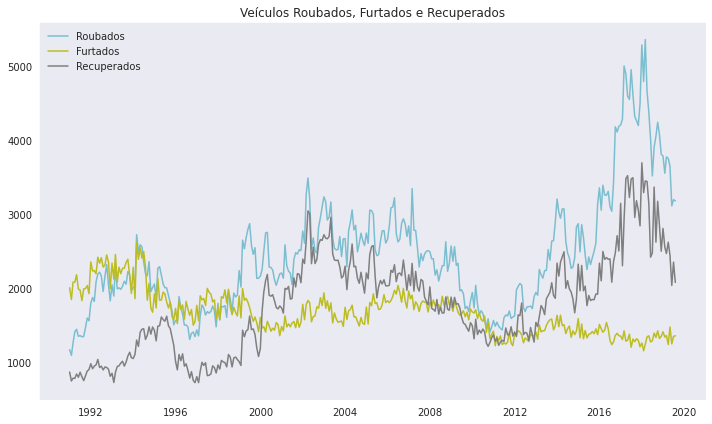

In [0]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(rio['data'], rio['roubo_veiculo'], label='Roubados', color=[123/255, 190/255, 207/255])
ax.plot(rio['data'], rio['furto_veiculos'], label='Furtados', color=[188/255, 189/255, 34/255])
ax.plot(rio['data'], rio['recuperacao_veiculos'], label='Recuperados', color=[127/255, 127/255, 127/255])
plt.grid(False)
plt.title('Veículos Roubados, Furtados e Recuperados')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Vericamos que o número de veículos roubados variou consideravelmente ao longo do período em questão. Após uma forte queda na segunda metade da primeira década dos anos 2000, o número de veículos roubados disparou até atingir seu [pico em 2018](https://odia.ig.com.br/rio-de-janeiro/2018/04/5531788-roubo-de-carros-bate-recorde-historico-no-rio.html).

O número de veículos recuperados acompanhou, durante a maior parte do tempo o número de roubos, em alguns momentos com os números das duas séries se aproximando significativamente, o que pode indicar uma melhor abordagem das forças de segurança ao problema em alguns peroídos.

Já o número de furtos manteve-se estável com leve queda durante todo o período analisado.

Continuando com a análise de ocorrências com veículos, vamos criar uma coluna para representar a taxa de veículos recuperados para cada veículo roubado/furtado. Para isso, vamos dividir a coluna `recuperacao_veiculos` pela soma das colunas `roubo_veiculo` e `furto_veiculos`.

In [0]:
rio['taxa_veiculos'] = round(rio['recuperacao_veiculos'] / (rio['roubo_veiculo'] + rio['furto_veiculos']), 2)
rio['taxa_veiculos'].head()

0    0.27
1    0.25
2    0.24
3    0.22
4    0.23
Name: taxa_veiculos, dtype: float64

Agora vamos visualizar esta taxa.

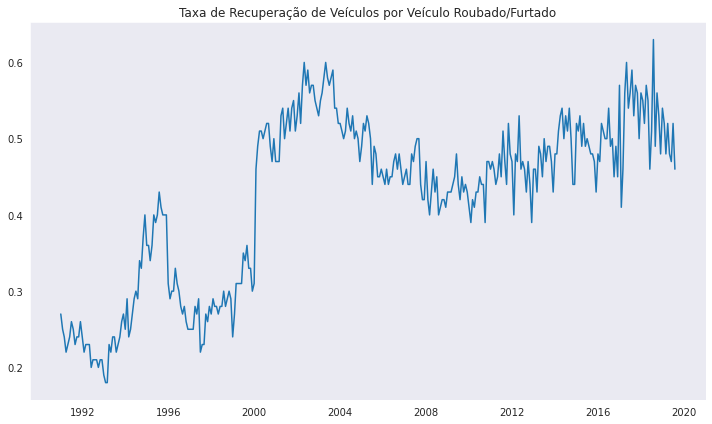

In [0]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(rio['data'], rio['taxa_veiculos'])
plt.grid(False)
plt.title('Taxa de Recuperação de Veículos por Veículo Roubado/Furtado')
plt.tight_layout()
plt.show()

Percebemos que a taxa de veículos recuperados por veículo roubado/furtado apresentou forte crescimento no começo dos anos 2000, o que faz perfeito sentido, já que foi nesta época, de acordo com gráfico anterior, que o número de recuperações superou o número de furtos veículos.

Após este grande aumento, a taxa oscilou bastante até atignir seu no mesmo período em que o número de roubos também cheogu ao ápice. Desde então, o gráfico apresenta queda, o que também faz sentido se considerarmos que o número de roubos também vêm caindo. No entanto, de uma forma geral, podemos notar que houve um aumento na eficácia das forças de segurança em recuperar veículos roubados ou furtados. 

## **Homicídios Dolosos**

Continuando com as análises, vamos agora trabalhar com o número de homicídios dolosos no estado do Rio de Janeiro. Nesta etapa vamos:

* Explorar os dados da coluna;
* Lidar com *outliers*;
* Construir um modelo preditivo com o `fbprophet`.

Incialmente, vamos verificar o valor máximo, mínimo e médio da coluna.

In [0]:
print('Maior registro de homicídios dolosos em um mês: ', rio['hom_doloso'].max())
print('Menor registro de homicídios dolosos em um mês: ', rio['hom_doloso'].min())
print('Média mensal de homicídios dolosos: ', round(rio['hom_doloso'].mean(), 2))

Maior registro de homicídios dolosos em um mês:  831
Menor registro de homicídios dolosos em um mês:  272
Média mensal de homicídios dolosos:  504.56


São mais de 500 ocorrências de homcídios dolosos desde 1991, em uma série que vairia de 272 a 831 casos.

Vamos criar um histograma para verificarmos a distribuição dos valores.

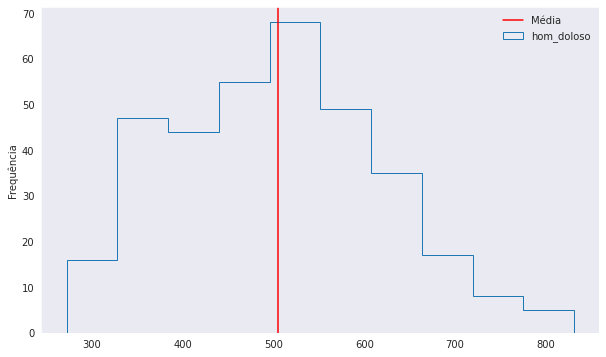

In [0]:
rio['hom_doloso'].plot.hist(histtype = 'step', legend=True, figsize=(10, 6))
plt.axvline(rio['hom_doloso'].mean(), label='Média', c='red')
plt.legend(frameon=False)
plt.ylabel('Frequência')
plt.grid(False)
plt.show()

Os valores estão realtivamente bem distribuídos, com a maior parte dos dados em torno da média. No entanto, existem alguns valores mais altos com baixa frequência, que podem ser *outliers*. Vamos criar um *boxplot* para invertigar melhor esta possibilidade.

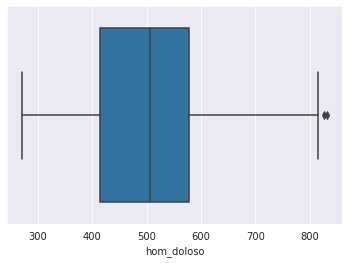

In [0]:
sns.boxplot(rio['hom_doloso']);

O gráfico apresenta alguns *outliers* superiores. 

Para plotar este gráfico, o `seaborn` considera *outliers* superiores como valores que são maiores que o terceiro quartil em 1.5 vezes a diferença entre o terceiro quartil e o primeiro quartil.

Para calcularmos este valor, vamos primeiro verificar o valor de cada quartil.

In [0]:
rio['hom_doloso'].describe()

count    344.000000
mean     504.555233
std      113.774481
min      272.000000
25%      413.750000
50%      507.000000
75%      577.250000
max      831.000000
Name: hom_doloso, dtype: float64

O terceiro quartil tem valor 577.25 e o primeiro é igual a 413.75. Agora vamos fazer a conta.

In [0]:
outliers = 577.25 + (577.25 - 413.75) * 1.5
outliers

822.5

Valores acima de 822.5 são então considerados *outliers*. Vamos verificar a porcentagem de valores que estão acima deste limite.

In [0]:
round(rio[rio['hom_doloso'] > outliers].shape[0] / rio.shape[0] * 100, 2)

0.58

Apenas 0.58% dos valores são *outiliers*. Vamos excluir estes valores enquanto selecionamos apenas as colunas `data` e `hom_doloso` para um novo *dataframe*. Assim, já estamos preparando os dados para gerar o modelo preditivo.

In [0]:
rio_prophet = rio[rio['hom_doloso'] < 822.5].loc[:, ['data', 'hom_doloso']]
rio_prophet.set_index(keys='data', drop=True, inplace=True)
rio_prophet.head()

,hom_doloso
data,
1991-01-01,657
1991-02-01,732
1991-03-01,713
1991-04-01,634
1991-05-01,650


Apenas para termos certeza, vamos plotar novamente o gráfico e verificar se os *outliers* sumiram.

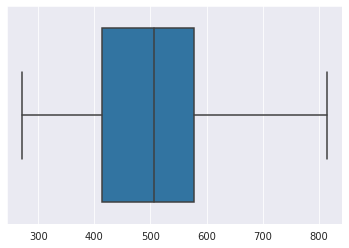

In [0]:
sns.boxplot(rio_prophet);

Como esperado, não existem mais *outliers*.

Em uma útilma etapa antes de criarmos o modelo, vamos resetar o índice e renomear as colunas para o padrão exigido pelo `fbprophet`.


In [0]:
prophet_df = rio_prophet.reset_index().rename(columns={'data': 'ds', 'hom_doloso': 'y'})
prophet_df.head()

,ds,y
0,1991-01-01,657
1,1991-02-01,732
2,1991-03-01,713
3,1991-04-01,634
4,1991-05-01,650


In [0]:
prophet_df.tail()

,ds,y
337,2019-04-01,360
338,2019-05-01,345
339,2019-06-01,332
340,2019-07-01,309
341,2019-08-01,318


### **Prophet**

O [Prophet](https://facebook.github.io/prophet/) é uma ferramenta de previsão implementado tanto em Python quanto em R, desenvolvida pelo Facebook. É rápido e fornece previsões completamente automatizadas que podem ser ajustadas manualmente por cientistas e analistas de dados.

Utilizando esta ferramenta, vamos rapidamente criar e plotar um modelo de previsão para os próximos 12 meses.

In [0]:
model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=12, freq='M')

forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


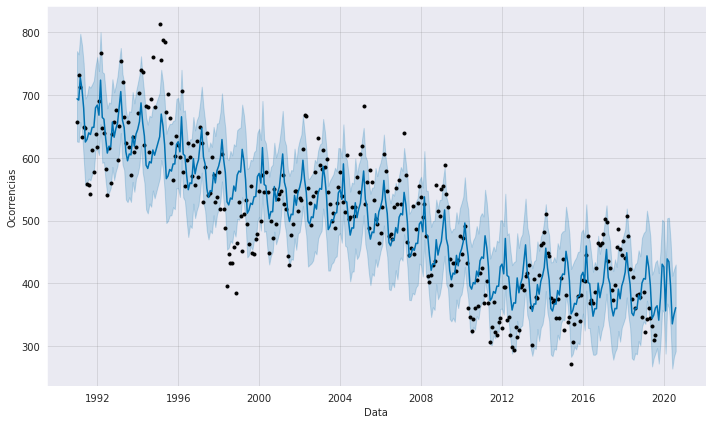

In [0]:
model.plot(forecast, xlabel='Data', ylabel='Ocorrencias');

O modelo criado mostra que o número de homicídios no Estado do Rio de Janeiro vem reduzindo ano a ano, com topos e fundos cada vez mais baixos, o que denota uma clara tendência de queda. Ainda, podemos notar que a previsão pra o próximo ano é que esse comportamente se mantenha.

Vamos agora plotar os componentes do modelo criado. Desta forma, poderemos ver mais clramente a tendência e o comportamento dentro do período de um ano.

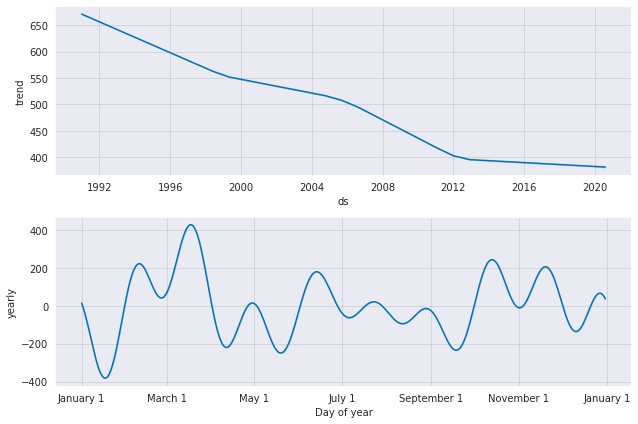

In [0]:
model.plot_components(forecast);

No primeiro gráfico podemos ver mais claramente a forte tendência de queda do número total de homícidios desde 1991 e que a previsão indica que os números deverão continuar neste ritmo.

Além disso, percebe-se que nos meses de feveiro, março e outubro, o número de ocorrências é maior, enquanto em janeiro, junho e setembro os valores são menores.

Os motivos desse compornamento não ficam claro e fogem do escopo deste projeto. No entanto, a partir destas informações as autoridades têm melhores condições de investigar as causas, bem como de implementar medidas para melhor proteger a sociedade.


### **Avaliação do Modelo**

Para avaliar o modelo, vamos empregar uma técnica de validação cruzada, através da função `cross_validation` do `prophet`. Para tal, vamos considerar um horizonte de 180 dias.

In [0]:
df_cv = cross_validation(model, horizon='180 days')
df_cv.head()

INFO:fbprophet:Making 108 forecasts with cutoffs between 1992-09-21 00:00:00 and 2019-02-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1992-10-01,973.959018,972.855543,975.203608,638,1992-09-21
1,1992-11-01,-116.169886,-120.552072,-111.551946,658,1992-09-21
2,1992-12-01,1930.210351,1921.451123,1938.742859,677,1992-09-21
3,1993-01-01,354.291934,340.318848,368.394837,597,1992-09-21
4,1993-02-01,515.891557,495.698047,536.252402,651,1992-09-21


Vamos então calcular o [erro percentual absoluto médio](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) ou MAPE, na sigla em inglês. O MAPE é uma medida da precisão de um modelo de previsão, por exemplo, na estimativa de tendências, também usada como uma função de perda para problemas de regressão em *machine learning*.

In [0]:
df_p = performance_metrics(df_cv, ['mape'])
df_p.head()

,horizon,mape
0,18 days,0.111847
1,19 days,0.111211
2,20 days,0.111126
3,21 days,0.114842
4,22 days,0.116959


O MAPE está em torno de 10%, o que é um medida satisfatória para o escopo deste projeto.

Podemos também plotar o gráfico do MAPE para cada horizonte de previsão.

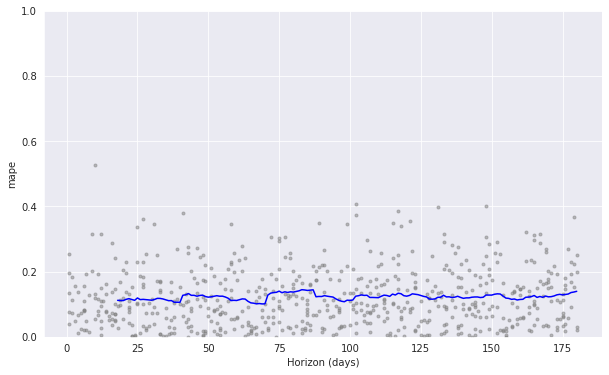

In [0]:
plot_cross_validation_metric(df_cv, metric='mape');
plt.ylim(0,1)
plt.show()

Como esperado, vemos que o erro médio aumenta quanto maior o horizonte da previsão, mas sem atingir o marca de 15%. Assim, consideramos que o modelo atingiu um resultado satisfatório.

## **Conclusão**

Ao longo deste projeto, foram realizadas análises dos números de crimes cometidos no Estado do Rio de Janeiro no período entre 1991 e 2019. Todo o processo foi dividio em quatro etapas:

* Análise exploratória;
* Limpeza dos dados;
* Análise dos crimes envolvendo roubo e furto de veíulos;
* Criação de um modelo preditivo para os caso de homícios dolosos.

Com isso, podemos tirar algumas conclusões dos dados, entre elas:

* O estado se tornou mais eficiente na recuperção de veículos roubados;
* O número de roubos de veículos aumentou drasticamente na última década;
* Números de furtos de veículos têm estado estáveis desde a década de 1990;
* Os casos de homícios dolosos apresentam forte tendência de de queda ao longo de todo o período e espera-se que continue assim.
